# Dating Textual Documents

# The prediction we are hoping to make
Given a short text in English, we wish to perform a classification in predicting the year (or the decade in which) it was written. The writing style of a written work from, say the 1800s, is certainly very different from that of a modern text, and we hope to build a model that can recognize this difference in a consistent way. The related, but different, problem of "author identification" has been tackled before (see e.g. [1] and [2]). 

[1] https://web.stanford.edu/class/cs224n/reports/2760185.pdf <br/>
[2] https://brage.bibsys.no/xmlui/bitstream/handle/11250/2353615/12344_FULLTEXT.pdf?sequence=1

# Data sources
- http://www.gutenberg.org/
- https://books.google.com/ngrams
- https://googlebooks.byu.edu/x.asp (more advanced word tool)
- Google Books (for retrieving publishing dates)
- https://www.goodreads.com/shelf/show/project-gutenberg (a list with 500+ books, the text of which will constitute our dataset)

# Cleaning the data 

<b> Scraping gutenberg.org and goodreads.com to retrieve the relevant texts and their publishing year </b>

From gutenberg.org we want to retrieve as many books as possible in .txt format. The website has about 60 000 books in its catalog, not all of which are of interst to us, e.g. those that are in a different language than English. We think that limiting  our dataset to fiction books with English as its original language makes our dataset more uniform and will prove beneficial for analysis later on. Fortunately, goodreads.com has a catalog which lists 500+ books that more or less satisfy these criteria. We used the data from goodreads.com to obtain the dataset of relevant books (and their publishing year), which we then used to scrape gutenberg.org to retrieve the actual texts. 

<b> Pre-processing a text </b>

Given a written work that can be accessed from gutenberg.org, we wish to (eventually) obtain a dataset which captures word and punctuation frequency, distribution of sentence lengths, and possibly other features. NLTK makes the process of retrieving word frequencies relatively simple. Using the "FreqDist" class, we can produce a list with all words and the number of times they appear in the form of a list of tuples: [(<word>, <word count>), ...]. 

Concerns questions and ideas about how we should clean the data:

1) Do we want all genres of written documents, or just e.g. fictional writing?

2) Stemmatizing/lemmatizing words? 

3) Should we distinguish between lower and uppercase words, or not? Initally we thought it would be a good this to make the set of words uniform in terms of case: consider the case where a word is the first of a sentence and thus have the first of its letter capitalized versus when it does not and have all letters lowercase. In terms of frequency, we'd like to count them as the same word. On the other hand, when it comes to names, we do want to keep the capitalization. It turns out that Google n-grams is case-sensitive. So we definitely want our dataset to be so as well. It really depends on the importance the frequency metric will have for our model. Perhaps we only care about the fact that a word <i> occurs </i> in our dataset, and not its frequency.

4) do we analyze the entirety of the written work, or smaller paragraphs of it? If the paragraphs are too short, this potentially diminishes the informativeness of word frequency; if a paragraph consists of 500 words and 2/3 of these are generic words such as "and", "if" and "but", then perhaps too little room is left for epoch-characteristic words. 

5) Google n-grams "charts the frequencies of any set of comma-delimited search strings using a yearly count of n-grams found in sources printed between 1500 and 2008 in Google's text corpora". However, the frequency for any given year should depend on <i> the number of works that were published in that given year </i>. It most likely is the case that fewer works from the 1500s are incorporated in Google's text corpora than those of the 2000's. So the question is whether Google n-grams really capture the <i> relative commonness </i> of a word between time periods? UPDATE: upon closer inspection, Google n-grams actually measures the <i> relative </i> frequency of a given word for the set of works within given time period.
   

# Data visualization

The following libraries need to be installed to be imported: pandas, nltk, and matplotlib.

In [2]:
import pandas as pd
from nltk.tokenize import TweetTokenizer
import nltk
import matplotlib.pyplot as plt
from urllib.request import urlopen, urlretrieve
import urllib

Load the goodreads_catalog.csv and gutenberg_catalog.csv.

goodreads_catalog.csv contains title, author, and publishing date information.

gutenberg_catalog.csv contains title and book id information.

In [3]:
df = pd.read_csv('goodreads_catalog.csv', sep=',')
df.columns = ['title','author','year']
df.head(5)

,title,author,year
0,The Mysterious Affair at Styles,Agatha Christie,1920
1,Pride and Prejudice,Jane Austen,1813
2,The Picture of Dorian Gray,Oscar Wilde,1890
3,Jane Eyre,Charlotte Brontë,1847
4,The Time Machine,H.G. Wells,1895


In [5]:
df2 = pd.read_csv('gutenberg_catalog.csv', sep=',')
df2.columns = ['title','author','book_id']
df2.head(5)

,title,author,book_id
0,Healthful Sports for Young Ladies,St. Sernin,57057
1,Winning his Wings,Percy F. Westerman,57056
2,"Baily's Magazine of Sports and Pastimes, Volum...",Various,57055
3,Flat Machine Knitting and Fabrics,H. D. Buck,57054
4,The Fall of the Great Republic (1886-88),Henry Standish Coverdale,57049


Merge the dataframes from goodreads_catalog.csv and gutenberg_catalog.csv so matching titles will contains information about author, publishing date, and book id information. 

In [6]:
combined = pd.merge(df, df2, on='title')

In [7]:
combined.head(5)

,title,author_x,year,author_y,book_id
0,The Mysterious Affair at Styles,Agatha Christie,1920,Agatha Christie,863
1,Pride and Prejudice,Jane Austen,1813,Jane Austen,42671
2,Pride and Prejudice,Jane Austen,1813,Jane Austen,1342
3,The Picture of Dorian Gray,Oscar Wilde,1890,Oscar Wilde,26740
4,The Picture of Dorian Gray,Oscar Wilde,1890,Oscar Wilde,4078


We deleted all duplicates titles so we consider the first instant as the correct book. 

In [14]:
combined = combined.sort_values(by='book_id')

In [15]:
combined = combined.drop_duplicates(subset='title')

In [16]:
combined.head(5)

,title,author_x,year,author_y,book_id
681,Alice's Adventures in Wonderland,Lewis Carroll,1865,Lewis Carroll,11
86,Peter Pan,J.M. Barrie,1904,James M. Barrie,16
239,Aesop's Fables,Aesop,560,Aesop,21
247,Paradise Lost,John Milton,1667,John Milton,26
8,The Time Machine,H.G. Wells,1895,H. G. Wells,35


In [20]:
#combined = combined.sort_values(by='year')
combined = combined[combined['year'] > 0]

# Visualization # 1
Show the frequency of the number of books we have for each year. We willl consider the years after 1800's for better visualization. As we can see, we don't have an abundance of books for each year as of now. However, with an improved parser we hope to obtain at least 15 books for each 5 year period. Moreover, splitting the texts into chunks will yield a considerably larger dataset for each year.

In [23]:
frequency = combined['year'].value_counts()

In [24]:
frequency = frequency.sort_index()

In [25]:
frequency = frequency[frequency.index > 1800]

Text(0,0.5,'Number of Books')

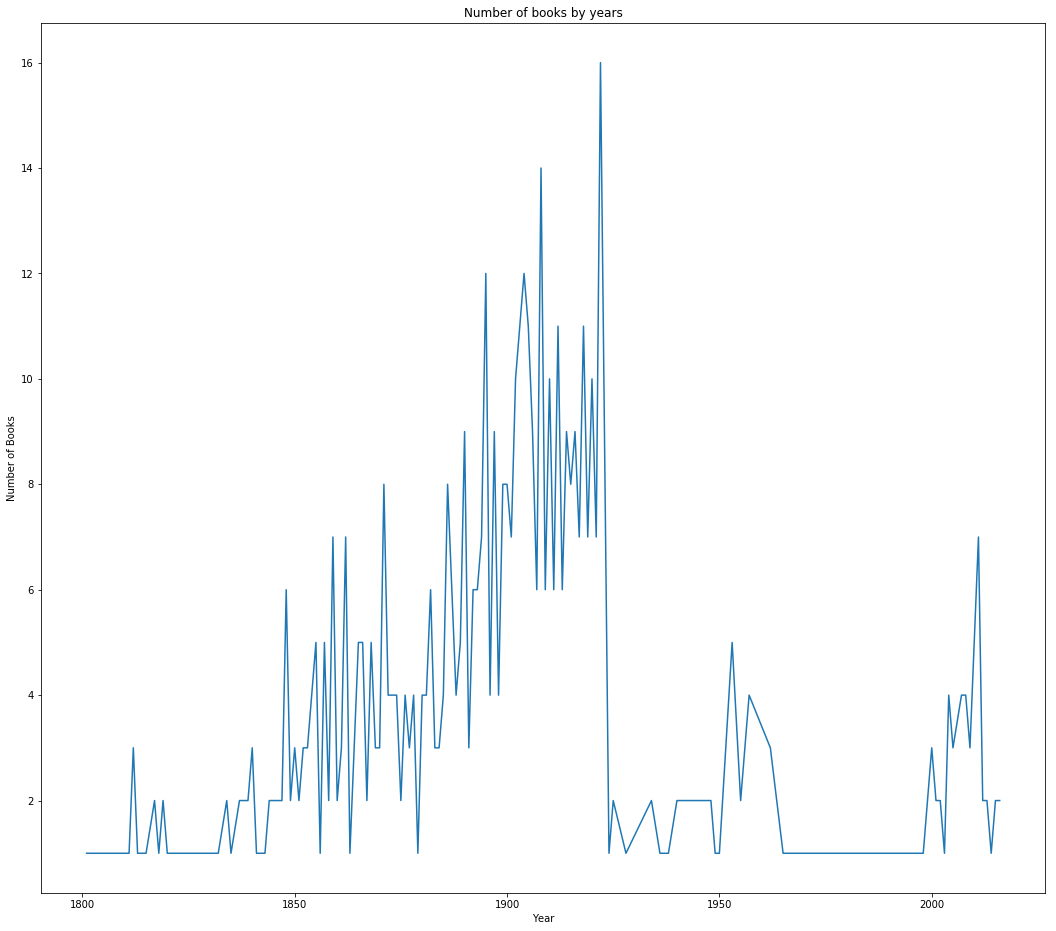

In [26]:
ax = frequency.plot(kind='line', figsize=(18,16), title='Number of books by years')
ax.set_xlabel("Year")
ax.set_ylabel("Number of Books")

# Visualization # 2
Show the frequency of the 50 most common used words/punctuation in "Pride and Prejudice"

In [32]:
file = open("books/book1342.txt",'r')
text=file.read()

tokenizer = TweetTokenizer()
tokens = tokenizer.tokenize(text)
fdist = nltk.FreqDist(tokens)
d = {'word': list(dict(fdist).keys()), 'frequency':list(dict(fdist).values())}

df = pd.DataFrame(d, columns=['word', 'frequency'])
df = df.sort_values(by='frequency')
total_number_of_words = len(df)
most_common_words_df = df.tail(50)

Text(0,0.5,'Number of Recurrence')

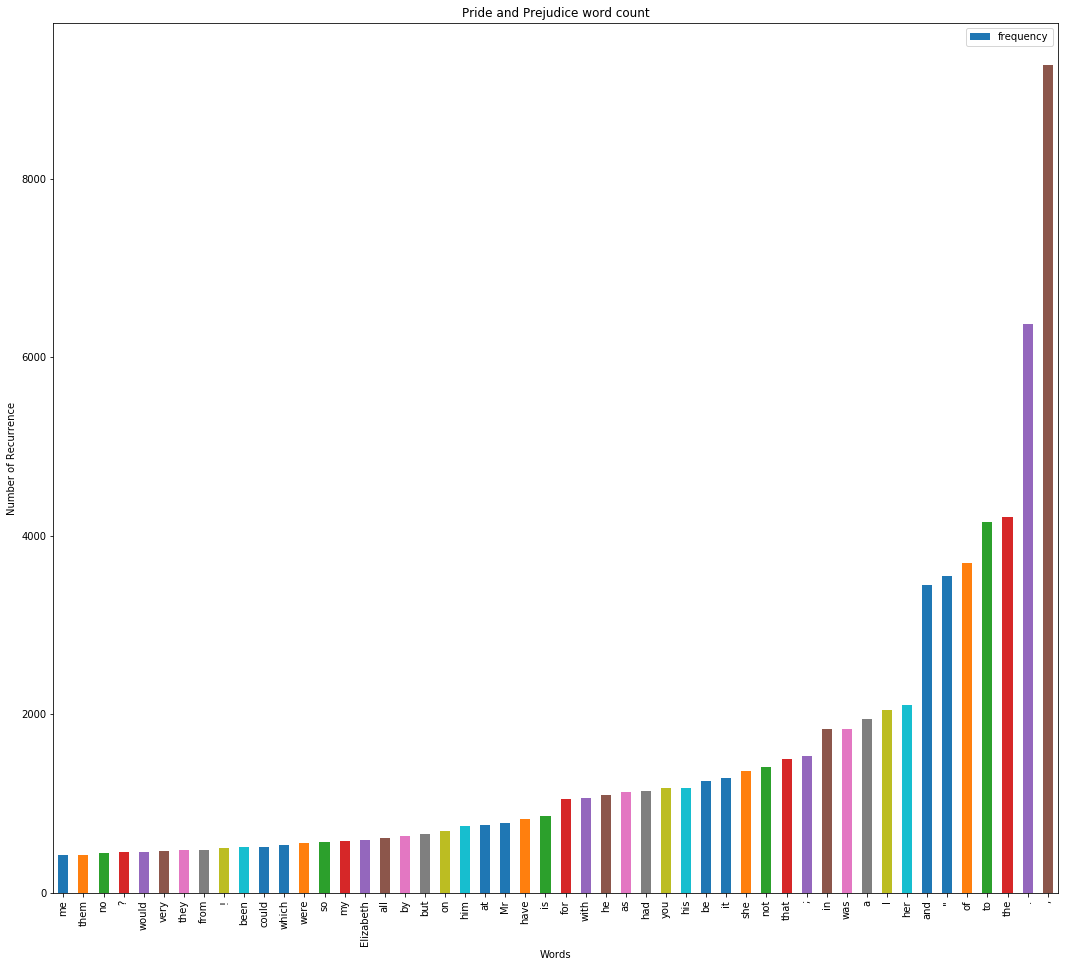

In [33]:
ax = most_common_words_df.plot.bar(x="word", y="frequency",figsize=(18,16), title='Pride and Prejudice word count')
ax.set_xlabel("Words")
ax.set_ylabel("Number of Recurrence")

# Visualization # 3
Show the frequency of the word "the" with the years of 1800 to 1900. Since "the" is such a generic word, it is perhaps not too surprising that no relationship or pattern is observed. Moreover, with more books to relationships will hopefully be found.

In [ ]:
the_percentages = []
years = []
tknzr = TweetTokenizer()

for index, row in combined.iterrows():
        book_id = int(row['book_id'])
        year = int(row['date'])
        if year > 1800 and year < 1900:
            print(book_id, year)
            try:
                file = open("Test_books/book{}.txt".format(book_id),'r')
                text = file.read()
                fdist = nltk.FreqDist(tknzr.tokenize(text))
                the_percentages.append(fdist["the"]/len(tknzr.tokenize(s)))
                years.append(year)


            except (UnicodeDecodeError, FileNotFoundError)  as e:
                pass
    
    

the_freq_df = pd.DataFrame({"years" : years, "the" : the_percentages})

In [ ]:
the_freq_df.head(20)

In [ ]:
ax = the_freq_df.plot.scatter(x="years", y="the",figsize=(18,16), title='Years (1800-1900) percent of "the"')
ax.set_ylabel("% of \"the\" in book")
ax.set_xlabel("Year")

In [ ]:
the_freq_df["years"].corr(the_freq_df["the"])

As seen in the correlation, there is almost no correlation between year and % of "the".